In [1]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor
import random
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
import seaborn as sns

In [2]:
import gc
from tensorflow.keras import backend as K

# At the end of each iteration
K.clear_session()
gc.collect()


0

In [7]:
# Load and preprocess images using tf.data API for optimized performance
def load_images(folder, label):
    file_paths = [os.path.join(folder, filename) for filename in os.listdir(folder)]
    labels = [label] * len(file_paths)
    return file_paths, labels

# Paths
folder_benign_train = '/kaggle/input/skin-cancer-malignant-vs-benign/train/benign'
folder_malignant_train = '/kaggle/input/skin-cancer-malignant-vs-benign/train/malignant'
folder_benign_test = '/kaggle/input/skin-cancer-malignant-vs-benign/test/benign'
folder_malignant_test = '/kaggle/input/skin-cancer-malignant-vs-benign/test/malignant'

In [ ]:
# Load images and labels
X_benign_train, y_benign_train = load_images(folder_benign_train, 0)
X_malignant_train, y_malignant_train = load_images(folder_malignant_train, 1)
X_benign_test, y_benign_test = load_images(folder_benign_test, 0)
X_malignant_test, y_malignant_test = load_images(folder_malignant_test, 1)

# Combine and split datasets
X_train = X_benign_train + X_malignant_train
y_train = y_benign_train + y_malignant_train
X_test = X_benign_test + X_malignant_test
y_test = y_benign_test + y_malignant_test

In [5]:
# Convert lists to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

In [6]:
# Shuffle the data
def shuffle_data(X, y):
    s = np.arange(X.shape[0])
    np.random.shuffle(s)
    return X[s], y[s]

X_train, y_train = shuffle_data(X_train, y_train)
X_test, y_test = shuffle_data(X_test, y_test)

In [7]:
# Split the training set into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [8]:
# tf.data Dataset creation
import tensorflow as tf

def preprocess_image(image_path, label):
    # Read the image from the file
    image = tf.io.read_file(image_path)
    
    # Decode the image to a tensor
    image = tf.image.decode_image(image, channels=3)
    
    # Ensure that the image has a known shape
    image.set_shape([None, None, 3])
    
    # Resize the image to the required dimensions
    image = tf.image.resize(image, [224, 224])
    
    # Normalize the image to [0, 1] range
    image = tf.cast(image, tf.float32) / 255.0
    
    return image, label


train_dataset = tf.data.Dataset.from_tensor_slices((X_train_split, y_train_split))
train_dataset = train_dataset.map(preprocess_image).shuffle(buffer_size=1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val_split, y_val_split))
val_dataset = val_dataset.map(preprocess_image).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.map(preprocess_image).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
# Model Building
def build_model(input_shape, filters, kernel_sizes, dropout_rates, learning_rate):
    model = Sequential()
    model.add(Conv2D(filters[0], kernel_size=(kernel_sizes[0], kernel_sizes[0]), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rates[0]))

    model.add(Conv2D(filters[1], kernel_size=(kernel_sizes[1], kernel_sizes[1]), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rates[1]))

    model.add(Conv2D(filters[2], kernel_size=(kernel_sizes[2], kernel_sizes[2]), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rates[2]))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [10]:
# Genetic algorithm setup
def generate_initial_population(population_size):
    population = []
    for _ in range(population_size):
        filters = [random.choice([32, 64, 128, 256]) for _ in range(3)]
        kernel_sizes = [random.choice([3, 5, 7]) for _ in range(3)]
        dropout_rates = [random.uniform(0.3, 0.6) for _ in range(3)]
        population.append((filters, kernel_sizes, dropout_rates))
    return population

In [11]:
def crossover_and_mutate(selected_individuals, mutation_rate):
    next_generation = []
    for i in range(len(selected_individuals)):
        parent1 = selected_individuals[i]
        parent2 = selected_individuals[(i + 1) % len(selected_individuals)]
        
        # Crossover
        crossover_point = random.randint(1, len(parent1[0]) - 1)
        child1_filters = parent1[0][:crossover_point] + parent2[0][crossover_point:]
        child1_kernels = parent1[1][:crossover_point] + parent2[1][crossover_point:]
        child1_dropouts = parent1[2][:crossover_point] + parent2[2][crossover_point:]
        
        child2_filters = parent2[0][:crossover_point] + parent1[0][crossover_point:]
        child2_kernels = parent2[1][:crossover_point] + parent1[1][crossover_point:]
        child2_dropouts = parent2[2][:crossover_point] + parent1[2][crossover_point:]
        
        # Mutation
        if random.random() < mutation_rate:
            mutation_index = random.randint(0, len(child1_filters) - 1)
            child1_filters[mutation_index] = random.choice([32, 64, 128, 256])
            child1_kernels[mutation_index] = random.choice([3, 5, 7])
            child1_dropouts[mutation_index] = random.uniform(0.3, 0.6)

        if random.random() < mutation_rate:
            mutation_index = random.randint(0, len(child2_filters) - 1)
            child2_filters[mutation_index] = random.choice([32, 64, 128, 256])
            child2_kernels[mutation_index] = random.choice([3, 5, 7])
            child2_dropouts[mutation_index] = random.uniform(0.3, 0.6)
        
        next_generation.append((child1_filters, child1_kernels, child1_dropouts))
        next_generation.append((child2_filters, child2_kernels, child2_dropouts))
    
    return next_generation

In [12]:
def evaluate_fitness(individual, input_shape, lr, epochs):
    filters, kernel_sizes, dropout_rates = individual
    model = build_model(input_shape, filters, kernel_sizes, dropout_rates, learning_rate=lr)

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(train_dataset,
                        validation_data=val_dataset,  
                        epochs=epochs, verbose=0, 
                        callbacks=[early_stopping])

    val_loss, val_accuracy = model.evaluate(val_dataset, verbose=0)
    return val_accuracy

In [13]:
def genetic_algorithm(population_size, generations, mutation_rate, input_shape, lr, epochs):
    population = generate_initial_population(population_size)
    
    for generation in range(generations):
        fitness_scores = []
        for individual in population:
            fitness = evaluate_fitness(individual, input_shape, lr, epochs)
            fitness_scores.append(fitness)
        
        selected_individuals = [x for _, x in sorted(zip(fitness_scores, population), reverse=True)][:int(0.5*population_size)]
        population = crossover_and_mutate(selected_individuals, mutation_rate)
    
    best_individual = selected_individuals[0]
    return best_individual

In [14]:
# Run Genetic Algorithm
best_model_params = genetic_algorithm(population_size=5, generations=3, mutation_rate=0.1, input_shape=(224, 224, 3), lr=0.001, epochs=5)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1725126352.675923     106 service.cc:145] XLA service 0x7b36640098d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725126352.675997     106 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725126352.676003     106 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1725126371.816048     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [15]:
# Best model final training
final_model = build_model(input_shape=(224, 224, 3), 
                          filters=best_model_params[0], 
                          kernel_sizes=best_model_params[1], 
                          dropout_rates=best_model_params[2], 
                          learning_rate=0.001)

In [16]:
# Callbacks
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = final_model.fit(train_dataset, 
                          validation_data=val_dataset, 
                          epochs=30, 
                          callbacks=[checkpoint, lr_scheduler])

Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 297ms/step - accuracy: 0.6458 - loss: 5.7280 - val_accuracy: 0.5928 - val_loss: 2.5923 - learning_rate: 0.0010
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step - accuracy: 0.7203 - loss: 1.3254 - val_accuracy: 0.6723 - val_loss: 0.8685 - learning_rate: 0.0010
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.7510 - loss: 0.9282 - val_accuracy: 0.5985 - val_loss: 0.6926 - learning_rate: 0.0010
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step - accuracy: 0.7785 - loss: 0.7237 - val_accuracy: 0.7443 - val_loss: 0.5997 - learning_rate: 0.0010
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step - accuracy: 0.7870 - loss: 0.5511 - val_accuracy: 0.7936 - val_loss: 0.7142 - learning_rate: 0.0010
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.7983 - loss: 0.5035 - val_accuracy: 0.6951 - val_loss: 0.9882 - learning_rate: 0.0010
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step - accuracy: 0.7775 - loss: 0.

21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 201ms/step


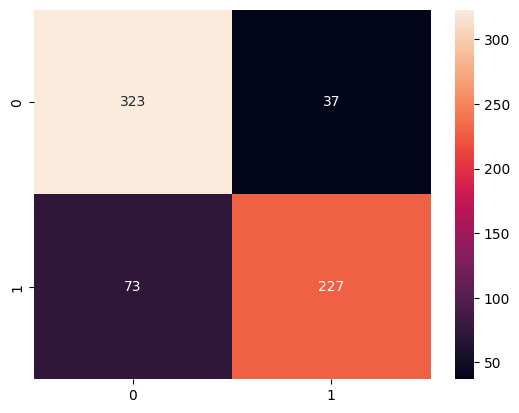

Precision: 0.8598484848484849, Recall: 0.7566666666666667, F1 Score: 0.8049645390070922


In [17]:
# Predictions and Confusion Matrix
y_pred = np.argmax(final_model.predict(test_dataset), axis=-1)
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.show()

# Calculate additional metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f'Precision: {precision}, Recall: {recall}, F1 Score: {f1}')

In [18]:
# Plot training accuracy over epochs
def plot_training_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Plot ROC curve
def plot_roc_curve(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

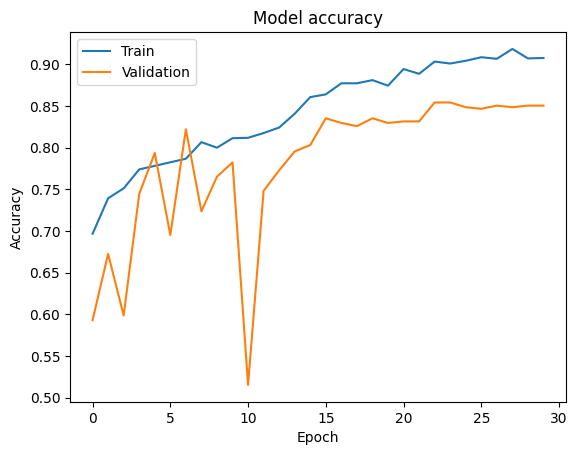

In [20]:
# Plot the accuracy
plot_training_accuracy(history)